# AMPS to Zarr 

The Plan (outline)
- read in (some, many?) NetCDF files
- strip unneccessary variables
- squeeze time dimension from non-varying 2D fields
- write (and later append) to zarr in GCS


In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import os

import gcsfs
from tqdm import tqdm
# from tqdm.autonotebook import tqdm
import fsspec

import xarray as xr

xr.set_options(display_style="html");
# xr.show_versions()

# Dask Startup

In [2]:
# xr.show_versions()

In [3]:
## A chunk of code to start dask cluster
from dask.distributed import Client, progress
from dask_gateway import Gateway
gateway = Gateway()

In [46]:
if gateway.list_clusters():
    cluster_name = gateway.list_clusters()[0].name
    cluster = gateway.connect(cluster_name)
    print(f"\nConnecting to pre-existing cluster with {len(cluster.scheduler_info['workers'])} workers.")
else:
    cluster = gateway.new_cluster() 
    cluster.adapt(minimum=8, maximum=16)
    print("\nStarting up and connecting to new cluster.")

cluster
# cluster.scheduler_info


Starting up and connecting to new cluster.


In [47]:
client = cluster.get_client()
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-prod-dask-gateway.prod:80/prod.c9b72ce935cc44cbb6cd181ab810d7c7 Dashboard: /services/dask-gateway/clusters/prod.c9b72ce935cc44cbb6cd181ab810d7c7/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### setup runtime parameters

In [6]:
gcsdir = 'gs://ldeo-glaciology'
ampsdir = 'AMPS'
amps_ver = 'WRF_24'

# domain = 'domain_02'
# filepattern = 'wrfout_d02_20191231*'
# pattern = os.path.join(gcsdir, ampsdir, amps_ver, domain, filepattern)
# print(pattern)

domain = 'domain_03'
filepattern = 'wrfout_d03_20190930*'
pattern = os.path.join(gcsdir, ampsdir, amps_ver, domain, filepattern)
print(pattern)

gs://ldeo-glaciology/AMPS/WRF_24/domain_03/wrfout_d03_20190930*


### list the netcdf files

In [7]:
fs = gcsfs.GCSFileSystem(project='ldeo-glaciology', mode='ab', cache_timeout = 0)

In [8]:
NCs = fs.glob(pattern)
print(f"Total of {len(NCs)} wrf files.\n")
print(NCs[0])

Total of 8 wrf files.

ldeo-glaciology/AMPS/WRF_24/domain_03/wrfout_d03_2019093000_f003.nc


### a single URL

In [18]:
ds = []
openfile = fs.open(f'gs://{NCs[0]}', mode='rb') 
ds = xr.open_dataset(openfile, engine='h5netcdf', chunks={'south_north': -1, 'west_east': -1})

In [ ]:
# print(type(ds))
# print(ds.T2.chunks)

# print(ds.coords)

# # ds.T2.mean().compute()
# # ds.T2.plot()

### Loop through list of URLs

In [9]:
NCs_urls = ['gs://' + x + '#mode=bytes' for x in NCs]
print(NCs_urls[0])


openfile = fs.open(NCs_urls[0], mode='rb') 
ds = xr.open_dataset(openfile, engine='h5netcdf',chunks={'south_north': -1, 
                                                               'west_east': -1,
                                                               'Time': -1})
for i in tqdm(range(1, len(NCs_urls))):
    openfile = fs.open(NCs_urls[i], mode='rb') 
    temp = xr.open_dataset(openfile, engine='h5netcdf',chunks={'south_north': -1, 
                                                               'west_east': -1,
                                                               'Time': -1})
    ds = xr.concat([ds,temp],'Time')

    

gs://ldeo-glaciology/AMPS/WRF_24/domain_03/wrfout_d03_2019093000_f003.nc#mode=bytes


100%|██████████| 7/7 [00:09<00:00,  1.31s/it]


In [19]:
print(f"Total size for {ds.DX[0]/1000:.2f} km output: {ds.nbytes / 1e9:.3f} Gb\n")
ds

Total size for 2.67 km output: 2.680 Gb



<xarray.Dataset>
Dimensions:                (Time: 1, bottom_top: 60, bottom_top_stag: 61, soil_layers_stag: 4, south_north: 1035, south_north_stag: 1036, west_east: 675, west_east_stag: 676)
Coordinates:
    XLAT                   (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
    XLONG                  (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
    XTIME                  (Time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    XLAT_U                 (Time, south_north, west_east_stag) float32 dask.array<chunksize=(1, 1035, 676), meta=np.ndarray>
    XLONG_U                (Time, south_north, west_east_stag) float32 dask.array<chunksize=(1, 1035, 676), meta=np.ndarray>
    XLAT_V                 (Time, south_north_stag, west_east) float32 dask.array<chunksize=(1, 1036, 675), meta=np.ndarray>
    XLONG_V                (Time, south_north_stag, west_east) float32 dask.array<chunksize=(1, 1036, 675), meta=np.ndarray>
Dimensions without coordinates: Time, bottom_top, bottom_top_stag, soil_layers_stag, south_north, south_north_stag, west_east, west_east_stag
Data variables:
    Times                  (Time) |S19 dask.array<chunksize=(1,), meta=np.ndarray>
    LU_INDEX               (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
    ZNU                    (Time, bottom_top) float32 dask.array<chunksize=(1, 60), meta=np.ndarray>
    ZNW                    (Time, bottom_top_stag) float32 dask.array<chunksize=(1, 61), meta=np.ndarray>
    ZS                     (Time, soil_layers_stag) float32 dask.array<chunksize=(1, 4), meta=np.ndarray>
    DZS                    (Time, soil_layers_stag) float32 dask.array<chunksize=(1, 4), meta=np.ndarray>
    VAR_SSO                (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
    U                      (Time, bottom_top, south_north, west_east_stag) float32 dask.array<chunksize=(1, 60, 1035, 676), meta=np.ndarray>
    V                      (Time, bottom_top, south_north_stag, west_east) float32 dask.array<chunksize=(1, 60, 1036, 675), meta=np.ndarray>
    W                      (Time, bottom_top_stag, south_north, west_east) float32 dask.array<chunksize=(1, 61, 1035, 675), meta=np.ndarray>
    PH                     (Time, bottom_top_stag, south_north, west_east) float32 dask.array<chunksize=(1, 61, 1035, 675), meta=np.ndarray>
    PHB                    (Time, bottom_top_stag, south_north, west_east) float32 dask.array<chunksize=(1, 61, 1035, 675), meta=np.ndarray>
    T                      (Time, bottom_top, south_north, west_east) float32 dask.array<chunksize=(1, 60, 1035, 675), meta=np.ndarray>
    HFX_FORCE              (Time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    LH_FORCE               (Time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    TSK_FORCE              (Time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    HFX_FORCE_TEND         (Time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    LH_FORCE_TEND          (Time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    TSK_FORCE_TEND         (Time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    MU                     (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
    MUB                    (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
    P                      (Time, bottom_top, south_north, west_east) float32 dask.array<chunksize=(1, 60, 1035, 675), meta=np.ndarray>
    PB                     (Time, bottom_top, south_north, west_east) float32 dask.array<chunksize=(1, 60, 1035, 675), meta=np.ndarray>
    FNM                    (Time, bottom_top) float32 dask.array<chunksize=(1, 60), meta=np.ndarray>
    FNP                    (Time, bottom_top) float32 dask.array<chunksize=(1, 60), meta=np.

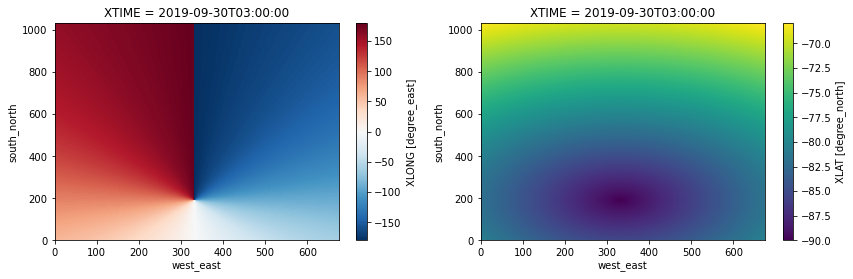

In [11]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,4))
ds.coords['XLONG'].isel(Time=0).plot(ax=ax1)
ds.coords['XLAT'].isel(Time=0).plot(ax=ax2)

In [12]:
# ds.coords['XTIME'].compute()

## REchunk

this looks cool but can be very inefficient

In [30]:
# ds = ds.chunk({"Time": 1})
ds.T

# ds.T2.mean(dim='Time').plot()
# ds.PSFC.mean().compute()

<xarray.DataArray 'T' (Time: 1, bottom_top: 60, south_north: 1035, west_east: 675)>
dask.array<open_dataset-8f95c5ec857451cea7faeeba61ce7b33T, shape=(1, 60, 1035, 675), dtype=float32, chunksize=(1, 60, 1035, 675), chunktype=numpy.ndarray>
Coordinates:
    XLAT     (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
    XLONG    (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
    XTIME    (Time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: Time, bottom_top, south_north, west_east
Attributes:
    FieldType:    [104]
    MemoryOrder:  XYZ
    description:  perturbation potential temperature (theta-t0)
    units:        K
    stagger:

## Alternatively using `open_mfdatasets`

Build list of URLs to public data in the bucket

### pre-process to deal with time

In [14]:
### GENERIC
def rename_timecoord(ds): 
#     .assign_coords(lat=ds.coords['XLAT'].squeeze('XTIME'), lon=ds.coords['XLONG'].squeeze('XTIME'))
    return ds.swap_dims({'Time':'XTIME'}) # .assign_coords(lat=ds_geo.coords['XLAT'].squeeze('Time'), lon=ds_geo.coords['XLONG'].squeeze('Time'))
    
### DROP NON TIME COORDS
# def non_time_coords(ds):
#     return [v for v in ds.data_vars
#             if 'Time' not in ds[v].dims]

# def drop_non_essential_vars_pop(ds):
#     return ds.drop(non_time_coords(ds))   

# ### DROP SOME COORDS
# def drop_coords(ds):
#     ds = ds.drop(['reference_time','feature_id', 'crs'])
#     return ds.reset_coords(drop=True)

# ### TEST ADDING TIME
# def add_time_dim(xda):
#     from datetime import datetime
    
#     xda = xda.expand_dims(Time = [datetime.now()])
#     return xda

In [15]:
%%time
NCs_urls = ['https://storage.googleapis.com/' + x + '#mode=bytes' for x in NCs] # needed for open_mfdataset

ds = xr.open_mfdataset(NCs_urls, engine='netcdf4', parallel=True,  
                       preprocess = rename_timecoord,
                       decode_cf=False,
#                        chunks={'XTIME': -1},
                       ).swap_dims({'XTIME':'Time'}).chunk({"Time": -1})

CPU times: user 528 ms, sys: 17.1 ms, total: 545 ms
Wall time: 37.4 s


In [16]:
# # this runs almost instantly  (from RABERNAT)
# ds = xr.open_mfdataset(NCs_urls, decode_times=False, chunks={'Time': 1},
#                        preprocess=drop_non_essential_vars_pop, decode_cf=False)

In [ ]:
%%time
ds = xr.open_mfdataset(NCs_urls, engine='netcdf4', parallel=True,   
                       concat_dim='Time', data_vars='minimal', coords='minimal', compat='override',
#                        combine='by_coords', 
#                        chunks={'Time': -1},
                       preprocess = rename_timecoord,
                      )

In [31]:
ds

<xarray.Dataset>
Dimensions:                (Time: 1, bottom_top: 60, bottom_top_stag: 61, soil_layers_stag: 4, south_north: 1035, south_north_stag: 1036, west_east: 675, west_east_stag: 676)
Coordinates:
    XLAT                   (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
    XLONG                  (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
    XTIME                  (Time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    XLAT_U                 (Time, south_north, west_east_stag) float32 dask.array<chunksize=(1, 1035, 676), meta=np.ndarray>
    XLONG_U                (Time, south_north, west_east_stag) float32 dask.array<chunksize=(1, 1035, 676), meta=np.ndarray>
    XLAT_V                 (Time, south_north_stag, west_east) float32 dask.array<chunksize=(1, 1036, 675), meta=np.ndarray>
    XLONG_V                (Time, south_north_stag, west_east) float32 dask.array<chunksize=(1, 1036, 675), meta=np.ndarray>
Dimensions without coordinates: Time, bottom_top, bottom_top_stag, soil_layers_stag, south_north, south_north_stag, west_east, west_east_stag
Data variables:
    Times                  (Time) |S19 dask.array<chunksize=(1,), meta=np.ndarray>
    LU_INDEX               (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
    ZNU                    (Time, bottom_top) float32 dask.array<chunksize=(1, 60), meta=np.ndarray>
    ZNW                    (Time, bottom_top_stag) float32 dask.array<chunksize=(1, 61), meta=np.ndarray>
    ZS                     (Time, soil_layers_stag) float32 dask.array<chunksize=(1, 4), meta=np.ndarray>
    DZS                    (Time, soil_layers_stag) float32 dask.array<chunksize=(1, 4), meta=np.ndarray>
    VAR_SSO                (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
    U                      (Time, bottom_top, south_north, west_east_stag) float32 dask.array<chunksize=(1, 60, 1035, 676), meta=np.ndarray>
    V                      (Time, bottom_top, south_north_stag, west_east) float32 dask.array<chunksize=(1, 60, 1036, 675), meta=np.ndarray>
    W                      (Time, bottom_top_stag, south_north, west_east) float32 dask.array<chunksize=(1, 61, 1035, 675), meta=np.ndarray>
    PH                     (Time, bottom_top_stag, south_north, west_east) float32 dask.array<chunksize=(1, 61, 1035, 675), meta=np.ndarray>
    PHB                    (Time, bottom_top_stag, south_north, west_east) float32 dask.array<chunksize=(1, 61, 1035, 675), meta=np.ndarray>
    T                      (Time, bottom_top, south_north, west_east) float32 dask.array<chunksize=(1, 60, 1035, 675), meta=np.ndarray>
    HFX_FORCE              (Time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    LH_FORCE               (Time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    TSK_FORCE              (Time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    HFX_FORCE_TEND         (Time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    LH_FORCE_TEND          (Time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    TSK_FORCE_TEND         (Time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    MU                     (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
    MUB                    (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
    P                      (Time, bottom_top, south_north, west_east) float32 dask.array<chunksize=(1, 60, 1035, 675), meta=np.ndarray>
    PB                     (Time, bottom_top, south_north, west_east) float32 dask.array<chunksize=(1, 60, 1035, 675), meta=np.ndarray>
    FNM                    (Time, bottom_top) float32 dask.array<chunksize=(1, 60), meta=np.ndarray>
    FNP                    (Time, bottom_top) float32 dask.array<chunksize=(1, 60), meta=np.

In [19]:
print(ds.U)

<xarray.DataArray 'U' (Time: 8, bottom_top: 60, south_north: 1035, west_east_stag: 676)>
dask.array<rechunk-merge, shape=(8, 60, 1035, 676), dtype=float32, chunksize=(8, 60, 1035, 676), chunktype=numpy.ndarray>
Coordinates:
    XTIME    (Time) datetime64[ns] dask.array<chunksize=(8,), meta=np.ndarray>
    XLAT_U   (Time, south_north, west_east_stag) float32 dask.array<chunksize=(8, 1035, 676), meta=np.ndarray>
    XLONG_U  (Time, south_north, west_east_stag) float32 dask.array<chunksize=(8, 1035, 676), meta=np.ndarray>
Dimensions without coordinates: Time, bottom_top, south_north, west_east_stag
Attributes:
    FieldType:    [104]
    MemoryOrder:  XYZ
    description:  x-wind component
    units:        m s-1
    stagger:      X


In [20]:
%%time
# ds.T2.chunk({"Time": -1}).mean().compute()
ds.T2.mean().compute()

# print(ds['T2'].shape)
# print(ds.var)

CPU times: user 25.5 ms, sys: 6.64 ms, total: 32.1 ms
Wall time: 3.86 s


<xarray.DataArray 'T2' ()>
array(241.47469, dtype=float32)

## Test write to zarr

To Do before writing to Zarr
- squeeze "Time" from all 2D fields
- trim fields


In [18]:
ds.coords['XLAT_U'].nbytes/1e6

22.38912

In [22]:
# ds.coords['XLAT'] = ds.XLAT.isel(Time=0)
# ds.coords['XLAT_U'] = ds.XLAT_U.isel(Time=0)
# ds.coords['XLAT_V'] = ds.XLAT_V.isel(Time=0)
# ds

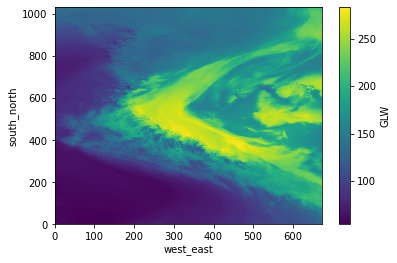

In [32]:
ds.GLW.mean(dim='Time').plot()
# ds.GLW.mean(dim='XTIME').plot()
# ds.U.nbytes/1e6

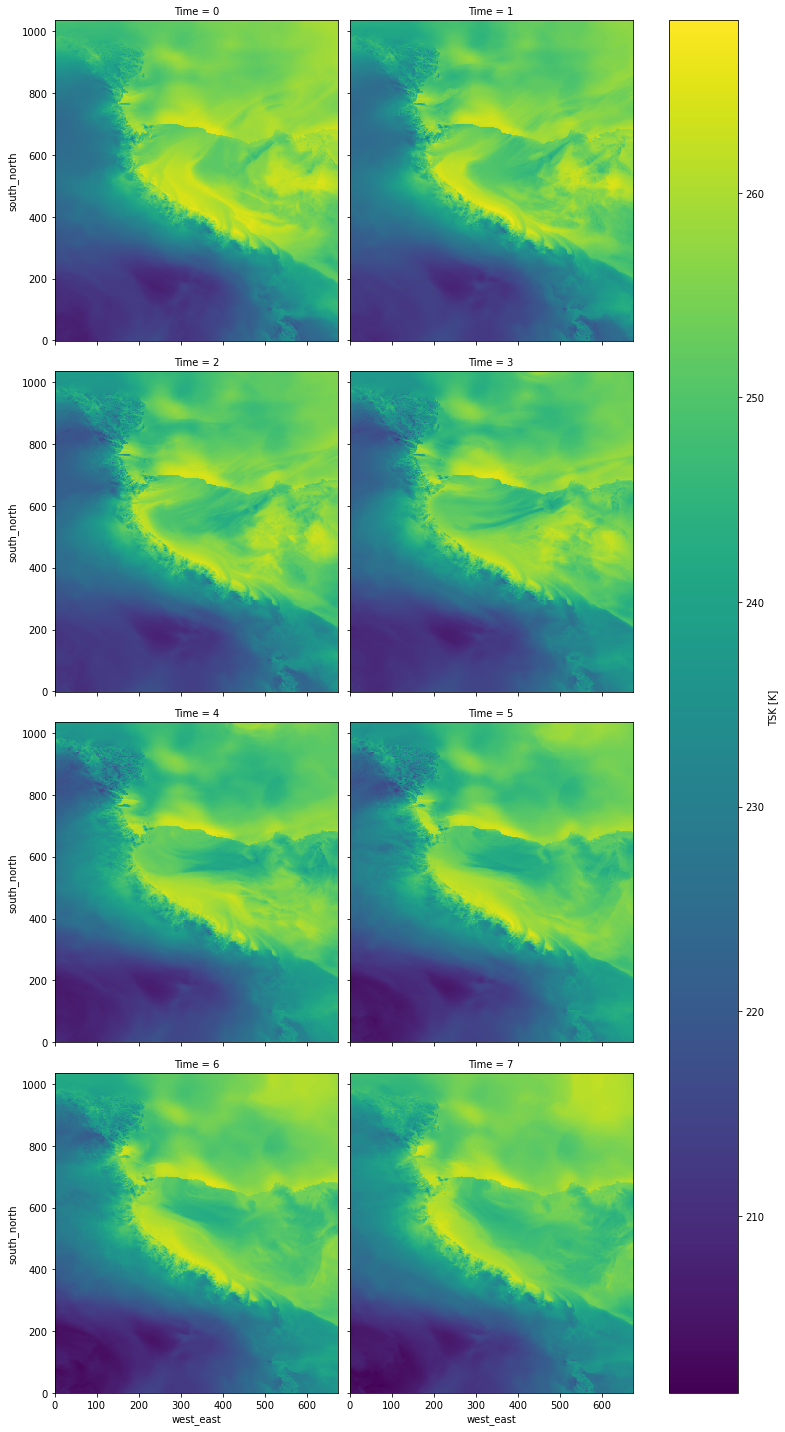

In [19]:
ds.TSK.isel(Time=slice(0,8,1)).plot(x='west_east',y='south_north',col='Time',col_wrap=2,size = 5)

In [22]:
vars_save = [
#     'U', 'V', 'W', 'PH', 'PHB', 'T', 'P', 'PB', 'P_HYD',
             'Q2', 'T2', 'PSFC', 'U10', 'V10',
#              'QVAPOR', 'QICE', 'QCLOUD', 'QRAIN', 'QSNOW', 
             'LANDMASK', 'HGT',
             'SST', 'SSTSK', 'TSK',
             'RAINC', 'RAINSH', 'RAINNC', 
             'QFX', 'HFX', 'LH', 'PBLH', 'ACSNOM', 'SWDOWN', 'LWDNB', 'GLW',
            'SNOW', 'SNOWH'
]

In [23]:
ds_stripped = ds[vars_save].persist()
print(f'{ds_stripped.nbytes/1e9} Gb')

print(f'Originally {ds.nbytes/1e9} Gb')

0.069862508 Gb
Originally 2.680378751 Gb


In [24]:
ds_stripped

<xarray.Dataset>
Dimensions:   (Time: 1, south_north: 1035, west_east: 675)
Coordinates:
    XLAT      (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
    XLONG     (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
    XTIME     (Time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: Time, south_north, west_east
Data variables:
    Q2        (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
    T2        (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
    PSFC      (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
    U10       (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
    V10       (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
    LANDMASK  (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
    HGT       (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
    SST       (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
    SSTSK     (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
    TSK       (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
    RAINC     (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
    RAINSH    (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
    RAINNC    (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
    QFX       (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
    HFX       (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
    LH        (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
    PBLH      (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
    ACSNOM    (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
    SWDOWN    (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
    LWDNB     (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
    GLW       (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
    SNOW      (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
    SNOWH     (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
Attributes:
    TITLE:                            OUTPUT FROM WRF V3.9.1.1 MODEL
    START_DATE:                      2019-09-30_00:00:00
    SIMULATION_START_DATE:           2019-09-30_00:00:00
    WEST-EAST_GRID_DIMENSION:        [676]
    SOUTH-NORTH_GRID_DIMENSION:      [1036]
    BOTTOM-TOP_GRID_DIMENSION:       [61]
    DX:                              [2666.667]
    DY:                              [2666.667]
    SKEBS_ON:                        [0]
    SPEC_BDY_FINAL_MU:               [1]
    USE_Q_DIABATIC:                  [0]
    GRIDTYPE:                        C
    DIFF_OPT:                        [1]
    KM_OPT:                          [4]
    DAMP_OPT:                        [3]
    DAMPCOEF:                        [0.21]
    KHDIF:                           [0.]
    KVDIF:                           [0.]
    MP_PHYSICS:                      [4]
    RA_LW_PHYSICS:                   [4]
    RA_SW_PHYSICS:                   [2]
    SF_SFCLAY_PHYSICS:               [2]
    SF_SURFACE_PHYSICS:              [2]
    BL_PBL_PHYSICS:                  [2]


In [25]:
outdir = os.path.join(gcsdir, ampsdir, amps_ver, domain, 'zarr-raw/')
# fs.glob(outdir)
fs.ls(outdir)

['ldeo-glaciology/AMPS/WRF_24/domain_03/zarr-raw/',
 'ldeo-glaciology/AMPS/WRF_24/domain_03/zarr-raw/wrfout_d03_201909.zarr',
 'ldeo-glaciology/AMPS/WRF_24/domain_03/zarr-raw/wrfout_d03_201909_2Donly.zarr',
 'ldeo-glaciology/AMPS/WRF_24/domain_03/zarr-raw/wrfout_d03_201909_2Donly_test.zarr',
 'ldeo-glaciology/AMPS/WRF_24/domain_03/zarr-raw/wrfout_d03_201909_2Donly_test2.zarr',
 'ldeo-glaciology/AMPS/WRF_24/domain_03/zarr-raw/wrfout_d03_201909_2Donly_test5.zarr',
 'ldeo-glaciology/AMPS/WRF_24/domain_03/zarr-raw/wrfout_d03_201909_2Donly_test6.zarr']

In [28]:
import json

with open('secrets/ldeo-glaciology-bc97b12df06b.json') as token_file:
    token = json.load(token_file)
# gcs = gcsfs.GCSFileSystem(token=token)

amps_mapper = fsspec.get_mapper(outdir + 'wrfout_d03_201909_3D_test_1time.zarr', mode='ab',
                            token=token)

In [29]:
# %%time
ds.to_zarr(amps_mapper, 
                    mode='w', 
#                     consolidated='True',
                   );

CPU times: user 6.48 s, sys: 594 ms, total: 7.07 s
Wall time: 8min 56s

## Read that zarr file back in

In [40]:
AMPS_gcs = xr.open_zarr(amps_mapper)

In [41]:
AMPS_gcs

<xarray.Dataset>
Dimensions:                (Time: 1, bottom_top: 60, bottom_top_stag: 61, soil_layers_stag: 4, south_north: 1035, south_north_stag: 1036, west_east: 675, west_east_stag: 676)
Coordinates:
    XLAT                   (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
    XLAT_U                 (Time, south_north, west_east_stag) float32 dask.array<chunksize=(1, 1035, 676), meta=np.ndarray>
    XLAT_V                 (Time, south_north_stag, west_east) float32 dask.array<chunksize=(1, 1036, 675), meta=np.ndarray>
    XLONG                  (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
    XLONG_U                (Time, south_north, west_east_stag) float32 dask.array<chunksize=(1, 1035, 676), meta=np.ndarray>
    XLONG_V                (Time, south_north_stag, west_east) float32 dask.array<chunksize=(1, 1036, 675), meta=np.ndarray>
    XTIME                  (Time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: Time, bottom_top, bottom_top_stag, soil_layers_stag, south_north, south_north_stag, west_east, west_east_stag
Data variables:
    ACGRDFLX               (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
    ACHFX                  (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
    ACLHF                  (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
    ACLWDNB                (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
    ACLWDNBC               (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
    ACLWDNT                (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
    ACLWDNTC               (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
    ACLWUPB                (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
    ACLWUPBC               (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
    ACLWUPT                (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
    ACLWUPTC               (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
    ACSNOM                 (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
    ALBBCK                 (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
    ALBEDO                 (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
    BF                     (Time, bottom_top_stag) float32 dask.array<chunksize=(1, 61), meta=np.ndarray>
    BH                     (Time, bottom_top) float32 dask.array<chunksize=(1, 60), meta=np.ndarray>
    C1F                    (Time, bottom_top_stag) float32 dask.array<chunksize=(1, 61), meta=np.ndarray>
    C1H                    (Time, bottom_top) float32 dask.array<chunksize=(1, 60), meta=np.ndarray>
    C2F                    (Time, bottom_top_stag) float32 dask.array<chunksize=(1, 61), meta=np.ndarray>
    C2H                    (Time, bottom_top) float32 dask.array<chunksize=(1, 60), meta=np.ndarray>
    C3F                    (Time, bottom_top_stag) float32 dask.array<chunksize=(1, 61), meta=np.ndarray>
    C3H                    (Time, bottom_top) float32 dask.array<chunksize=(1, 60), meta=np.ndarray>
    C4F                    (Time, bottom_top_stag) float32 dask.array<chunksize=(1, 61), meta=np.ndarray>
    C4H                    (Time, bottom_top) float32 dask.array<chunksize=(1, 60), meta=np.ndarray>
    CANWAT                 (Time, south_north, west_east) float32 dask.array<chunksize=(1

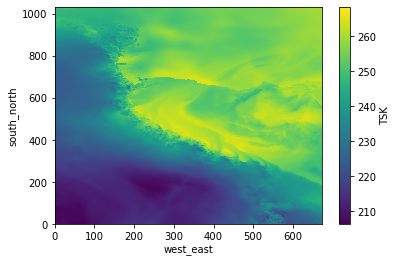

In [92]:
AMPS_gcs.TSK.mean(dim='Time').plot()


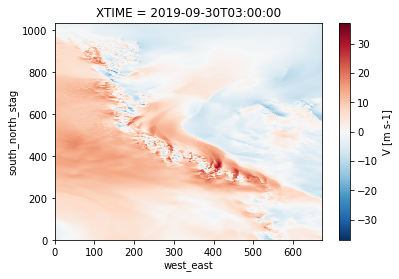

In [95]:
AMPS_gcs.V.isel(bottom_top=slice(0,1,1)).plot() #x='west_east',y='south_north',col='Time',col_wrap=2,size = 5)

## Append next time period to the same zarr

### when using 3-hourly file at a time

In [86]:
ds.XTIME.values

# ds = ds.swap_dims({"Time": "XTIME"})

# ds.rename_dims({"Time": "XTIME"})

# ds.assign_coords({"Time": "XTIME"})
# ds = ds.assign_coords(Time=ds.XTIME)

array(['2019-09-30T06:00:00.000000000'], dtype='datetime64[ns]')

In [87]:
ds = []
openfcoords = fs.open(f'gs://{NCs[1]}', mode='rb') 
ds = xr.open_dataset(openfile, engine='h5netcdf', chunks={'south_north': -1, 'west_east': -1})

In [88]:
import json

with open('secrets/ldeo-glaciology-bc97b12df06b.json') as token_file:
    token = json.load(token_file)
# gcs = gcsfs.GCSFileSystem(token=token)

amps_mapper = fsspec.get_mapper(outdir + 'wrfout_d03_201909_3D_test_1time.zarr', mode='ab',
                            token=token)

In [90]:
# %%time
# ds2.to_zarr("path/to/directory.zarr", append_dim="t")
ds.to_zarr(amps_mapper, mode="a", 
           append_dim="Time",
#            encoding={'Time': {'chunks': 1}}, 
           compute=False, 
           consolidated=True,
          )

ValueError: Invalid dtype for data variable: <xarray.DataArray 'Times' (Time: 1)>
dask.array<open_dataset-4d9c2bb2716dceb6f863ac00769553ccTimes, shape=(1,), dtype=|S19, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    XTIME    (Time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: Time dtype must be a subtype of number, datetime, bool, a fixed sized string, a fixed size unicode string or an object

### When doing 8 files at a time (daily groupings)

In [ ]:
filepattern = 'wrfout_d03_20190930*'
pattern = os.path.join(gcsdir, ampsdir, amps_ver, domain, filepattern)
print(pattern)

fs = gcsfs.GCSFileSystem(project='ldeo-glaciology', mode='ab', cache_timeout = 0)

In [ ]:
NCs = fs.glob(pattern)
print(f"Total of {len(NCs)} wrf files.\n")
print(NCs[0])

In [ ]:
NCs_urls = ['gs://' + x + '#mode=bytes' for x in NCs]
print(NCs_urls[0])


openfile = fs.open(NCs_urls[0], mode='rb') 
ds = xr.open_dataset(openfile, engine='h5netcdf',chunks={'south_north': -1, 
                                                               'west_east': -1,
                                                               'Time': -1})
for i in tqdm(range(1, len(NCs_urls))):
    openfile = fs.open(NCs_urls[i], mode='rb') 
    temp = xr.open_dataset(openfile, engine='h5netcdf',chunks={'south_north': -1, 
                                                               'west_east': -1,
                                                               'Time': -1})
    ds = xr.concat([ds,temp],'Time')

    

In [ ]:
print(f"Total size for {ds.DX[0]/1000:.2f} km output: {ds.nbytes / 1e9:.3f} Gb\n")
ds.T2

In [ ]:
ds = ds.chunk({"Time": -1})
ds.T2

# ds.T2.mean(dim='Time').plot()
# ds.PSFC.mean().compute()

In [ ]:
ds_stripped = ds[vars_save]
print(f'{ds_stripped.nbytes/1e9} Gb')

print(f'Originally {ds.nbytes/1e9} Gb')

In [ ]:
import json

with open('secrets/ldeo-glaciology-bc97b12df06b.json') as token_file:
    token = json.load(token_file)
# gcs = gcsfs.GCSFileSystem(token=token)

amps_mapper = fsspec.get_mapper(outdir + 'wrfout_d03_201909_2Donly_test2.zarr', mode='ab',
                            token=token)

In [ ]:
# %%time
# ds2.to_zarr("path/to/directory.zarr", append_dim="t")
ds_stripped.to_zarr(amps_mapper, mode="a", append_dim="Time")

# Read the APPENDED zarr file back in

In [ ]:
AMPS_gcs_ = xr.open_zarr(amps_mapper)

In [ ]:
x

In [ ]:
AMPS_gcs.XTIME.values

In [ ]:
AMPS_gcs.TSK.isel(Time=slice(0,16,1)).plot(x='west_east',y='south_north',col='Time',col_wrap=2,size = 5)

## Close your cluster, be a good denizen.

In [1]:
cluster.shutdown()

NameError: name 'cluster' is not defined